In [81]:
import numpy as np
import pandas as pd
import shutil
import os
from zipfile import ZipFile
import glob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import obspy
import glob2 as glob
from obspy.clients.fdsn import Client
from collections import defaultdict
import pyarrow

#### EQT picks

In [89]:
eqt = pd.read_parquet('eqtresults_2017.parquet')

#### Original events

In [46]:
# Get original events
file = 'endquakes_june2017.xml'
cat = obspy.core.event.read_events(file)
origins = [p.origins[0] for p in cat.events]
# magnitudes = [p.magnitudes[0] for p in cat.events]


times = [p.time for p in origins]
lats = [p.latitude for p in origins]
lons = [p.longitude for p in origins]
depths = [p.depth for p in origins]
arrivals = [len(p.arrivals) for p in origins]
origin_ids = [str(p.resource_id) for p in origins]
# mags = [p.mag for p in magnitudes]
# mag_type = [p.magnitude_type for p in magnitudes]
origin_dict = {'time':times,'latitude':lats,'longitude':lons,'depth':depths,'num_arrivals':arrivals,'origin_id':origin_ids}

events = pd.DataFrame.from_dict(origin_dict)
events['time'] = [str(t) for t in events['time']]
events.head()

,time,latitude,longitude,depth,num_arrivals,origin_id
0,2017-06-01T00:25:14.742000Z,48.0047,-129.1020,2.009700,8,None
1,2017-06-01T00:25:34.352000Z,47.9770,-129.0854,0.003594,4,None
2,2017-06-01T00:48:58.089000Z,48.0086,-129.0890,1.990300,6,None
3,2017-06-01T01:16:27.369000Z,48.0324,-129.1535,2.990300,4,None
4,2017-06-01T03:43:31.855000Z,47.9243,-129.0885,0.280310,6,None


In [ ]:
events.to_parquet(path='endjune2017_events.parquet',version='2.6')

#### Original picks

In [70]:
from obspy import read_inventory
client = Client("IRIS")
starttime = obspy.UTCDateTime("2017-06-01")
endtime = obspy.UTCDateTime("2017-06-30")
sta_metadata = client.get_stations(network="NV",
                                starttime=starttime,
                                endtime=endtime)

In [71]:
from collections import defaultdict

# Set up empty dictionary
dd = defaultdict(list)

for e in cat.events:
    arrs = e.origins[0].arrivals
    for count,p in enumerate(e.picks):
        
        # Pick/arrival info
        arr = [a for a in arrs if str(a.pick_id) == str(p.resource_id)]
        dd['phase'].append(arr[0].phase)
        dd['time_residual'].append(arr[0].time_residual)
        dd['time_weight'].append(arr[0].time_weight)
        dd['pick_time'].append(str(p.time))
        dd['network'].append(p.waveform_id.network_code)
        dd['station'].append(p.waveform_id.station_code)
        dd['channel'].append(p.waveform_id.channel_code)
        dd['pick_id'].append(str(p.resource_id))
        sta_code = f"{p.waveform_id.network_code}.{p.waveform_id.station_code}..{p.waveform_id.channel_code[:-1]}"
        dd['sta_code'].append(sta_code)
        location_code = p.waveform_id.location_code
        
        # Event info
        dd['ev_id'].append(str(e.resource_id))
        dd['ev_time'].append(str(e.origins[0].time))
        dd['ev_longitude'].append(e.origins[0].longitude)
        dd['ev_latitude'].append(e.origins[0].latitude)
        dd['ev_depth'].append(e.origins[0].depth)
        
        if e.magnitudes:
            dd['mag'].append(e.magnitudes[0].mag)
        else:
            dd['mag'].append(np.nan)
        
        

In [49]:
ground_truth = pd.DataFrame.from_dict(dd)
ground_truth.head()

,phase,time_residual,time_weight,pick_time,network,station,channel,pick_id,sta_code,ev_id,ev_time,ev_longitude,ev_latitude,ev_depth,mag
0,P,0.0001,1.000,2017-06-01T00:25:15.580000Z,NV,NCHR,EHZ,quakeml:/Arrival/NV/515094p1,NV.NCHR..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
1,S,0.0473,0.125,2017-06-01T00:25:16.530000Z,NV,NCHR,EHE,quakeml:/Arrival/NV/515094p2,NV.NCHR..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
2,P,0.0016,1.000,2017-06-01T00:25:15.810000Z,NV,ENWF,HHZ,quakeml:/Arrival/NV/515094p3,NV.ENWF..HH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
3,S,0.0258,0.250,2017-06-01T00:25:16.940000Z,NV,ENWF,HHE,quakeml:/Arrival/NV/515094p4,NV.ENWF..HH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
4,P,0.0004,1.000,2017-06-01T00:25:15.950000Z,NV,KEMF,EHZ,quakeml:/Arrival/NV/515094p5,NV.KEMF..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488


In [50]:
ground_truth['pick_time']=pd.to_datetime(ground_truth['pick_time'],format='%Y-%m-%dT%H:%M:%S.%fZ',errors='coerce')
ground_truth.head()

,phase,time_residual,time_weight,pick_time,network,station,channel,pick_id,sta_code,ev_id,ev_time,ev_longitude,ev_latitude,ev_depth,mag
0,P,0.0001,1.000,2017-06-01 00:25:15.580,NV,NCHR,EHZ,quakeml:/Arrival/NV/515094p1,NV.NCHR..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
1,S,0.0473,0.125,2017-06-01 00:25:16.530,NV,NCHR,EHE,quakeml:/Arrival/NV/515094p2,NV.NCHR..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
2,P,0.0016,1.000,2017-06-01 00:25:15.810,NV,ENWF,HHZ,quakeml:/Arrival/NV/515094p3,NV.ENWF..HH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
3,S,0.0258,0.250,2017-06-01 00:25:16.940,NV,ENWF,HHE,quakeml:/Arrival/NV/515094p4,NV.ENWF..HH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
4,P,0.0004,1.000,2017-06-01 00:25:15.950,NV,KEMF,EHZ,quakeml:/Arrival/NV/515094p5,NV.KEMF..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488


In [51]:
eqt['arrival_time']=pd.to_datetime(eqt['arrival_time'],infer_datetime_format=True)
eqt.head()

,file_name,network,station,instrument_type,station_lat,station_lon,station_elv,event_start_time,event_end_time,detection_probability,detection_uncertainty,arrival_time,probability,uncertainty,snr,phase
0,ENWF/NV.ENWF..HHZ__20170101T000000Z__20170102T...,NV,ENWF,HH,47.959766,-129.124479,-2361.0,2017-01-01 01:08:06.830000,2017-01-01 01:08:14.950000,0.44,None,2017-01-01 01:08:06.550,0.46,None,9.5,P
1,ENWF/NV.ENWF..HHZ__20170102T000000Z__20170103T...,NV,ENWF,HH,47.959766,-129.124479,-2361.0,2017-01-02 06:11:42.450000,2017-01-02 06:11:43.370000,0.9,None,2017-01-02 06:11:42.470,0.86,None,17.1,P
2,ENWF/NV.ENWF..HHZ__20170102T000000Z__20170103T...,NV,ENWF,HH,47.959766,-129.124479,-2361.0,2017-01-02 06:14:14.330000,2017-01-02 06:14:15.380000,0.41,None,2017-01-02 06:14:14.500,0.69,None,3.8,P
3,ENWF/NV.ENWF..HHZ__20170103T000000Z__20170104T...,NV,ENWF,HH,47.959766,-129.124479,-2361.0,2017-01-03 08:32:38.530000,2017-01-03 08:32:45.540000,0.89,None,2017-01-03 08:32:38.980,0.49,None,-2.5,P
4,ENWF/NV.ENWF..HHZ__20170103T000000Z__20170104T...,NV,ENWF,HH,47.959766,-129.124479,-2361.0,2017-01-03 10:34:34.720000,2017-01-03 10:34:36.980000,0.46,None,2017-01-03 10:34:34.940,0.36,None,2.6,P


In [52]:
ground_truth

,phase,time_residual,time_weight,pick_time,network,station,channel,pick_id,sta_code,ev_id,ev_time,ev_longitude,ev_latitude,ev_depth,mag
0,P,0.0001,1.0000,2017-06-01 00:25:15.580,NV,NCHR,EHZ,quakeml:/Arrival/NV/515094p1,NV.NCHR..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
1,S,0.0473,0.1250,2017-06-01 00:25:16.530,NV,NCHR,EHE,quakeml:/Arrival/NV/515094p2,NV.NCHR..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
2,P,0.0016,1.0000,2017-06-01 00:25:15.810,NV,ENWF,HHZ,quakeml:/Arrival/NV/515094p3,NV.ENWF..HH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
3,S,0.0258,0.2500,2017-06-01 00:25:16.940,NV,ENWF,HHE,quakeml:/Arrival/NV/515094p4,NV.ENWF..HH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
4,P,0.0004,1.0000,2017-06-01 00:25:15.950,NV,KEMF,EHZ,quakeml:/Arrival/NV/515094p5,NV.KEMF..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8207,P,-0.0196,0.7500,2017-06-30 22:32:45.125,NV,ENWF,HHZ,quakeml:/Arrival/NV/516822p3,NV.ENWF..HH,None,2017-06-30T22:32:43.525000Z,-129.120,48.0391,2.9903,0.70708
8208,S,0.0157,0.1875,2017-06-30 22:32:46.675,NV,ENWF,HHE,quakeml:/Arrival/NV/516822p4,NV.ENWF..HH,None,2017-06-30T22:32:43.525000Z,-129.120,48.0391,2.9903,0.70708
8209,P,0.0902,0.5000,2017-06-30 22:32:45.420,NV,KEMF,EHZ,quakeml:/Arrival/NV/516822p5,NV.KEMF..EH,None,2017-06-30T22:32:43.525000Z,-129.120,48.0391,2.9903,0.70708
8210,S,-0.0208,0.1875,2017-06-30 22:32:46.905,NV,KEMF,EHE,quakeml:/Arrival/NV/516822p6,NV.KEMF..EH,None,2017-06-30T22:32:43.525000Z,-129.120,48.0391,2.9903,0.70708


In [53]:
t1 = datetime(2017,6,1)
t2 = datetime(2017,6,30)

ground_truth = ground_truth[(ground_truth['pick_time']>t1) & (ground_truth['pick_time']<t2)]
eqt = eqt[(eqt['arrival_time']>t1) & (eqt['arrival_time']<t2)]

## Now that we have them both, let's compare them

In [78]:
# Sort both dataframes by time:
eqt.sort_values(by=['arrival_time'],inplace=True)
ground_truth.sort_values(by=['pick_time'],inplace=True)

# Merge dataframes, only merging picks if they have matching station ID, 
# phase type, and are within 0.1 s of each other
resid_max = 0.2
comp = pd.merge_asof(left=eqt,right=ground_truth,left_on=['arrival_time'],right_on=['pick_time'],left_by=['network','station','phase'],right_by=['network','station','phase'],tolerance = pd.Timedelta(resid_max,'seconds'),direction='nearest')


/tmp/ipykernel_3637309/3522982153.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth.sort_values(by=['pick_time'],inplace=True)


In [79]:
comp.head()

,file_name,network,station,instrument_type,station_lat,station_lon,station_elv,event_start_time,event_end_time,detection_probability,...,pick_time,channel,pick_id,sta_code,ev_id,ev_time,ev_longitude,ev_latitude,ev_depth,mag
0,nchr/NV.NCHR..EHZ__20170601T000000Z__20170602T...,NV,NCHR,EH,47.973751,-129.082092,-2152.0,2017-06-01 00:25:15.390000,2017-06-01 00:25:16.560000,0.4,...,2017-06-01 00:25:15.580,EHZ,quakeml:/Arrival/NV/515094p1,NV.NCHR..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
1,ENWF/NV.ENWF..HHZ__20170601T000000Z__20170602T...,NV,ENWF,HH,47.959766,-129.124479,-2361.0,2017-06-01 00:25:15.910000,2017-06-01 00:25:17.010000,0.41,...,2017-06-01 00:25:15.810,HHZ,quakeml:/Arrival/NV/515094p3,NV.ENWF..HH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
2,kemf/NV.KEMF..EHZ__20170601T000000Z__20170602T...,NV,KEMF,EH,47.948572,-129.098661,-2195.0,2017-06-01 00:25:15.970000,2017-06-01 00:25:17.510000,0.91,...,2017-06-01 00:25:15.950,EHZ,quakeml:/Arrival/NV/515094p5,NV.KEMF..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
3,nchr/NV.NCHR..EHZ__20170601T000000Z__20170602T...,NV,NCHR,EH,47.973751,-129.082092,-2152.0,2017-06-01 00:25:15.390000,2017-06-01 00:25:16.560000,0.4,...,2017-06-01 00:25:16.530,EHE,quakeml:/Arrival/NV/515094p2,NV.NCHR..EH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488
4,ENWF/NV.ENWF..HHZ__20170601T000000Z__20170602T...,NV,ENWF,HH,47.959766,-129.124479,-2361.0,2017-06-01 00:25:15.910000,2017-06-01 00:25:17.010000,0.41,...,2017-06-01 00:25:16.940,HHE,quakeml:/Arrival/NV/515094p4,NV.ENWF..HH,None,2017-06-01T00:25:14.742000Z,-129.102,48.0047,2.0097,0.81488


In [80]:
matched = comp.dropna(subset=['pick_id'])
print("EQT got ",str(len(matched)),'of the same picks as the',str(len(ground_truth)), ' in the original catalog')

EQT got  879 of the same picks as the 8051  in the original catalog


In [57]:
709/3567

0.19876647042332493

In [58]:
np.mean(ground_truth['mag'])

0.7636204487804856

In [59]:
np.mean(matched['mag'])

1.1250952432814707

In [60]:
len(matched[matched['station']=='ENWF'])

119

In [61]:
len(matched[matched['station']=='NCHR'])

370

In [62]:
len(matched[matched['station']=='KEMF'])

104

In [63]:
len(matched[matched['station']=='KEMO'])

116

In [64]:
445/957

0.46499477533960293

In [24]:
events.head()

,time,latitude,longitude,depth,num_arrivals,origin_id
0,2017-06-01 00:25:14.742,48.0047,-129.1020,2.009700,8,None
1,2017-06-01 00:25:34.352,47.9770,-129.0854,0.003594,4,None
2,2017-06-01 00:48:58.089,48.0086,-129.0890,1.990300,6,None
3,2017-06-01 01:16:27.369,48.0324,-129.1535,2.990300,4,None
4,2017-06-01 03:43:31.855,47.9243,-129.0885,0.280310,6,None


In [82]:
len(eqt)

2500

In [83]:
len(ground_truth)

8212

Text(0, 0.5, 'Number of Picks')

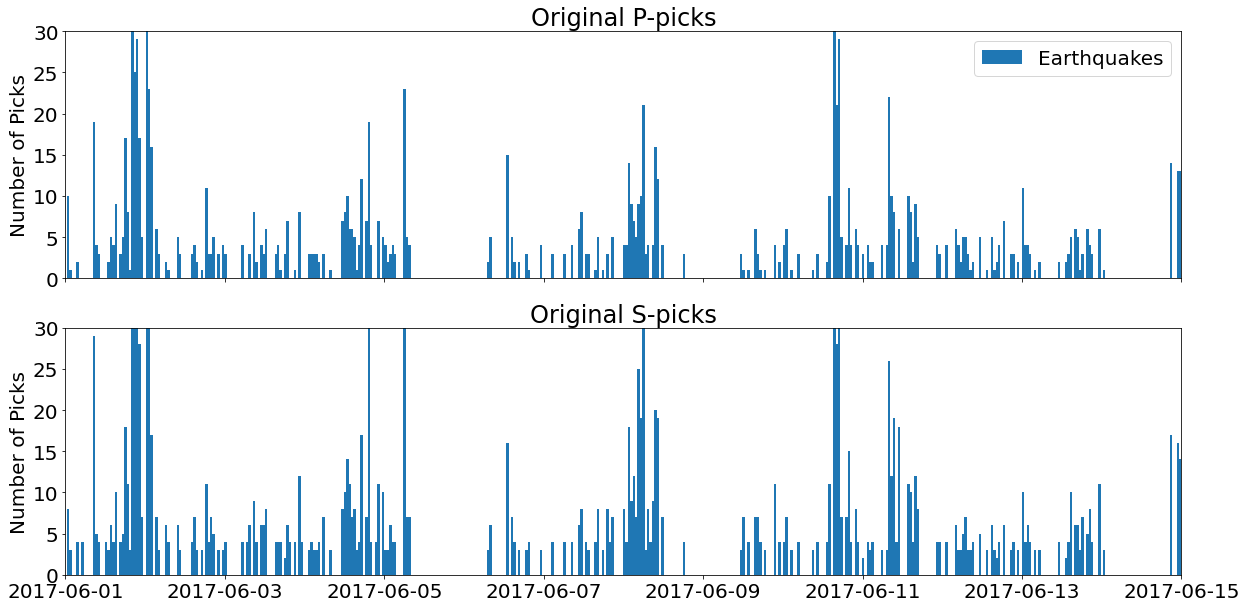

In [32]:
plt.rcParams.update({'font.size': 20})

php_picks = eqt[eqt['phase']=='P']
phs_picks = eqt[eqt['phase']=='S']

p_picks = ground_truth[ground_truth['phase']=='P']
s_picks = ground_truth[ground_truth['phase']=='S']

nbins= 500

# Filter by probability?

fig, axs = plt.subplots(2, figsize=(20,10),sharex=True,sharey=True)
axs[0].hist(p_picks['pick_time'],bins=nbins);
#axs[0].vlines(x=events['time'],ymin=0,ymax=30,colors ='r',linewidth=0.25)
axs[0].set_title('Original P-picks')
axs[1].hist(s_picks['pick_time'],bins=nbins);
#axs[1].vlines(x=events['time'],ymin=0,ymax=30,colors ='r',linewidth=0.25)
axs[1].set_title('Original S-picks')
axs[0].set_ylim([0,30])
axs[1].set_xlim([datetime(2017,6,1),datetime(2017,6,15)])

axs[0].legend(['Earthquakes','Picks'])
axs[0].set_ylabel('Number of Picks')
axs[1].set_ylabel('Number of Picks')

In [16]:
matched.columns

Index(['file_name', 'network', 'station', 'instrument_type', 'station_lat',
       'station_lon', 'station_elv', 'event_start_time', 'event_end_time',
       'detection_probability', 'detection_uncertainty', 'arrival_time',
       'probability', 'uncertainty', 'snr', 'phase', 'time_residual',
       'time_weight', 'pick_time', 'channel', 'pick_id', 'sta_code', 'ev_id',
       'ev_time', 'ev_longitude', 'ev_latitude', 'ev_depth', 'mag'],
      dtype='object')

Text(0, 0.5, 'Number of Picks')

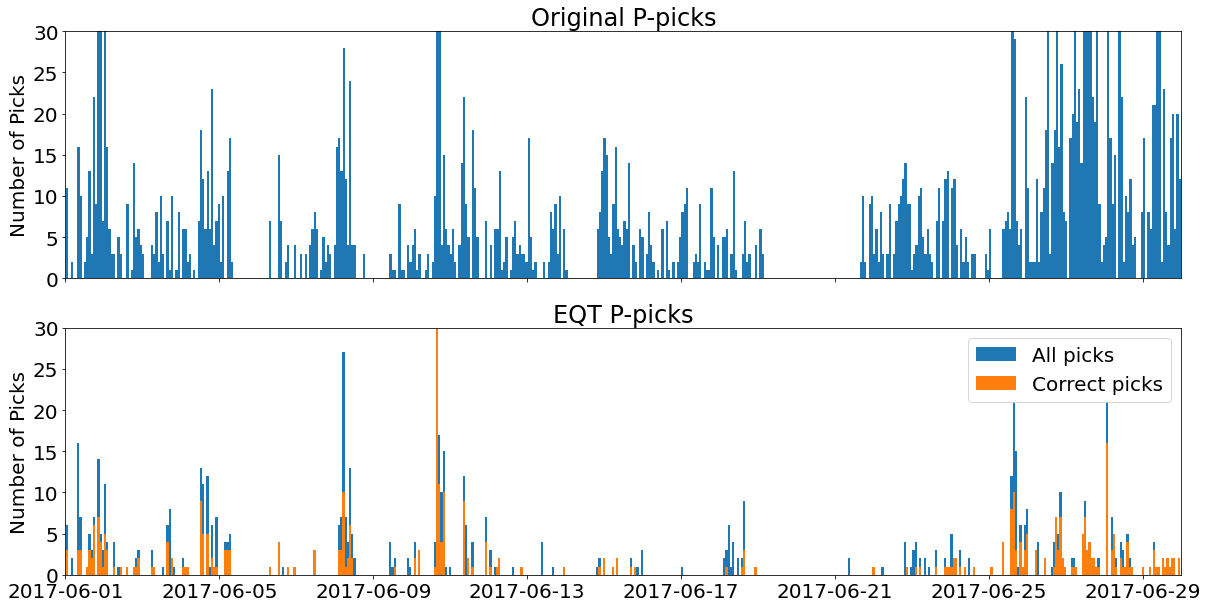

In [65]:
plt.rcParams.update({'font.size': 20})

php_picks = eqt[eqt['phase']=='P']
phs_picks = eqt[eqt['phase']=='S']

p_picks = ground_truth[ground_truth['phase']=='P']
s_picks = ground_truth[ground_truth['phase']=='S']

truep = matched[matched['phase']=='P']
trues = matched[matched['phase']=='S']

nbins= 500

# Filter by probability?

fig, axs = plt.subplots(2, figsize=(20,10),sharex=True,sharey=True)
axs[0].hist(p_picks['pick_time'],bins=nbins);
#axs[0].vlines(x=events['time'],ymin=0,ymax=30,colors ='r',linewidth=0.25)
axs[0].set_title('Original P-picks')
axs[1].hist(php_picks['arrival_time'],bins=nbins);
axs[1].hist(truep['arrival_time'],bins=nbins);
#axs[1].vlines(x=events['time'],ymin=0,ymax=30,colors ='r',linewidth=0.25)
axs[1].set_title('EQT P-picks')
axs[0].set_ylim([0,30])
axs[1].set_xlim([datetime(2017,6,1),datetime(2017,6,30)])

axs[1].legend(['All picks','Correct picks'])
axs[0].set_ylabel('Number of Picks')
axs[1].set_ylabel('Number of Picks')

Text(0, 0.5, 'Number of Picks')

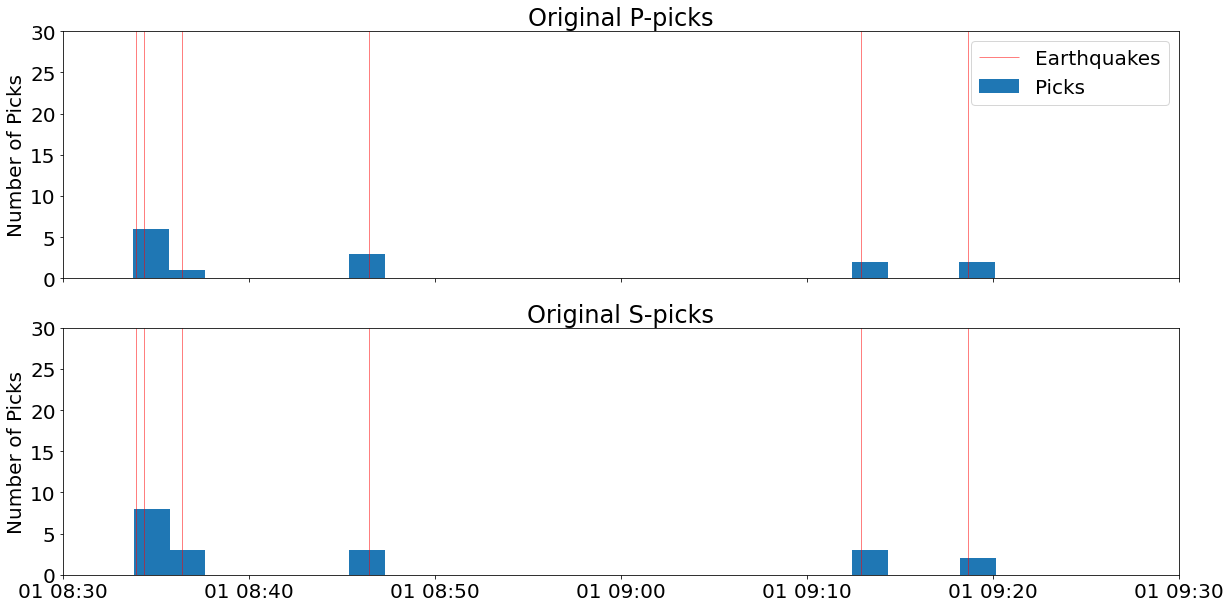

In [66]:
plt.rcParams.update({'font.size': 20})

php_picks = eqt[eqt['phase']=='P']
phs_picks = eqt[eqt['phase']=='S']

p_picks = ground_truth[ground_truth['phase']=='P']
s_picks = ground_truth[ground_truth['phase']=='S']

nbins= (15 * 60 * 24)

# Filter by probability?

fig, axs = plt.subplots(2, figsize=(20,10),sharex=True,sharey=True)
axs[0].hist(p_picks['pick_time'],bins=nbins);
axs[0].vlines(x=events['time'],ymin=0,ymax=30,colors ='r',linewidth=0.5)
axs[0].set_title('Original P-picks')
axs[1].hist(s_picks['pick_time'],bins=nbins);
axs[1].vlines(x=events['time'],ymin=0,ymax=30,colors ='r',linewidth=0.5)
axs[1].set_title('Original S-picks')
axs[0].set_ylim([0,30])
axs[1].set_xlim([datetime(2017,6,1,8,30),datetime(2017,6,1,9,30)])

axs[0].legend(['Earthquakes','Picks'])
axs[0].set_ylabel('Number of Picks')
axs[1].set_ylabel('Number of Picks')

(0.0, 20.0)

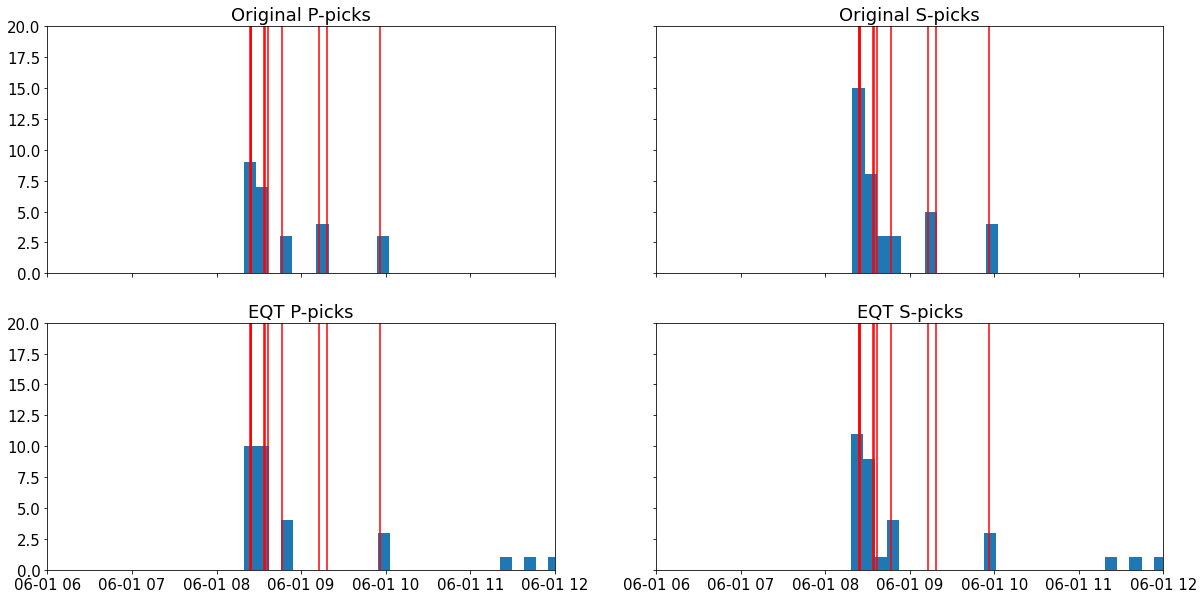

In [19]:
plt.rcParams.update({'font.size': 15})

php_picks = eqt[eqt['phase']=='P']
phs_picks = eqt[eqt['phase']=='S']

p_picks = ground_truth[ground_truth['phase']=='P']
s_picks = ground_truth[ground_truth['phase']=='S']

nbins= 5000

# Filter by probability?

fig, axs = plt.subplots(2,2, figsize=(20,10),sharex=True,sharey=True)
axs[0,0].hist(p_picks['pick_time'],bins=nbins);
axs[0,0].vlines(x=events['time'],ymin=0,ymax=30,colors ='r')
axs[0,0].set_title('Original P-picks')
axs[0,1].hist(s_picks['pick_time'],bins=nbins);
axs[0,1].vlines(x=events['time'],ymin=0,ymax=30,colors ='r')
axs[0,1].set_title('Original S-picks')
axs[1,0].hist(php_picks['arrival_time'],bins=nbins);
axs[1,0].set_title('EQT P-picks')
axs[1,0].vlines(x=events['time'],ymin=0,ymax=30,colors ='r')
axs[1,1].hist(phs_picks['arrival_time'],bins=nbins);
axs[1,1].set_title('EQT S-picks')
axs[1,1].vlines(x=events['time'],ymin=0,ymax=30,colors ='r')

axs[1,1].set_xlim([datetime(2017,6,1,6),datetime(2017,6,1,12)])
axs[1,1].set_ylim([0,20])

In [75]:
eqt.head()

,file_name,network,station,instrument_type,station_lat,station_lon,station_elv,event_start_time,event_end_time,detection_probability,detection_uncertainty,arrival_time,probability,uncertainty,snr,phase
0,ENWF/NV.ENWF..HHN__20170601T000000Z__20170602T...,NV,ENWF,HH,47.959766,-129.124479,-2361.0,2017-06-01 00:25:15.890000,2017-06-01 00:25:17.040000,0.29,NaN,2017-06-01 00:25:15.770,0.21,NaN,12.0,P
0,KEMF/NV.KEMF..EHE__20170601T000000Z__20170602T...,NV,KEMF,EH,47.948572,-129.098661,-2195.0,2017-06-01 00:25:16.020000,2017-06-01 00:25:17.370000,0.61,NaN,2017-06-01 00:25:15.910,0.54,NaN,11.4,P
0,NCHR/NV.NCHR..EHE__20170601T000000Z__20170602T...,NV,NCHR,EH,47.973751,-129.082092,-2152.0,2017-06-01 00:25:15.890000,2017-06-01 00:25:16.360000,0.28,NaN,2017-06-01 00:25:16.000,0.12,NaN,34.2,P
0,ENWF/NV.ENWF..HHN__20170601T000000Z__20170602T...,NV,ENWF,HH,47.959766,-129.124479,-2361.0,2017-06-01 00:25:15.890000,2017-06-01 00:25:17.040000,0.29,NaN,2017-06-01 00:25:16.890,0.57,NaN,15.4,S
0,KEMF/NV.KEMF..EHE__20170601T000000Z__20170602T...,NV,KEMF,EH,47.948572,-129.098661,-2195.0,2017-06-01 00:25:16.020000,2017-06-01 00:25:17.370000,0.61,NaN,2017-06-01 00:25:17.080,0.78,NaN,13.3,S


(0.0, 10.0)

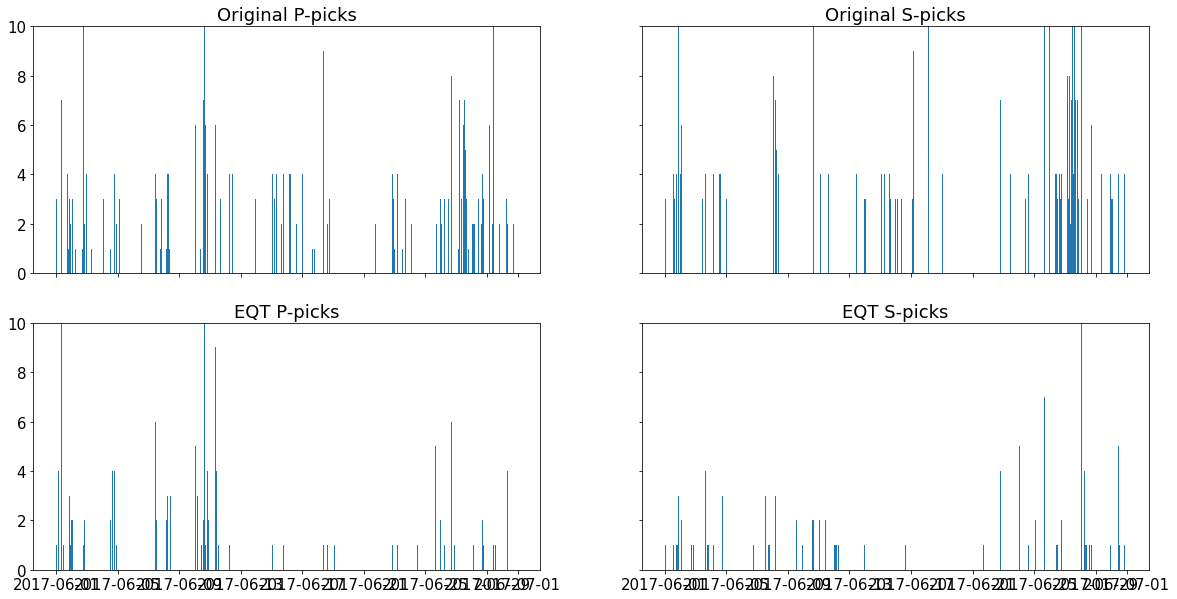

In [21]:
fig, axs = plt.subplots(2,2, figsize=(20,10),sharex=True,sharey=True)
axs[0,0].hist(p_picks['pick_time'],bins=nbins);
axs[0,0].set_title('Original P-picks')
axs[0,1].hist(s_picks['pick_time'],bins=nbins);
axs[0,1].set_title('Original S-picks')
axs[1,0].hist(php_picks['arrival_time'],bins=nbins);
axs[1,0].set_title('EQT P-picks')
axs[1,1].hist(phs_picks['arrival_time'],bins=nbins);
axs[1,1].set_title('EQT S-picks')

axs[1,1].set_ylim([0,10])

TypeError: function missing required argument 'day' (pos 3)

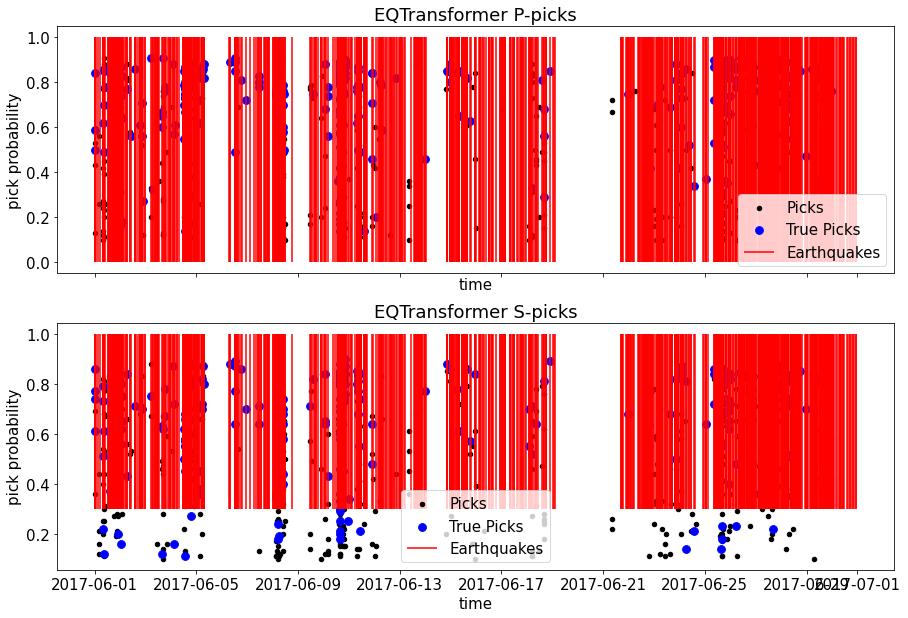

In [69]:
true_positives = comp[comp['pick_id'].notna()]

php_picks = eqt[eqt['phase']=='P']
phs_picks = eqt[eqt['phase']=='S']

p_picks = ground_truth[ground_truth['phase']=='P']
s_picks = ground_truth[ground_truth['phase']=='S']

true_p = true_positives[true_positives['phase']=='P']
true_s = true_positives[true_positives['phase']=='S']


# Filter by probability?
fig, axs = plt.subplots(2,1, figsize=(15,10),sharex=True)
plt.rcParams.update({'font.size': 15})

axs[0].scatter(php_picks['arrival_time'],php_picks['probability'],s=20,c='k')
axs[0].scatter(true_p['arrival_time'],true_p['probability'],s=60,c='b')
axs[0].vlines(x=events['time'],ymin=0,ymax=1,colors ='r')
axs[0].set_xlabel('time')
axs[0].set_ylabel('pick probability')
axs[0].set_title('EQTransformer P-picks')
axs[0].legend(['Picks','True Picks','Earthquakes'])

axs[1].scatter(phs_picks['arrival_time'],phs_picks['probability'],s=20,c='k')
axs[1].scatter(true_s['arrival_time'],true_s['probability'],s=60,c='b')
axs[1].vlines(x=events['time'],ymin=0.3,ymax=1,colors ='r')
axs[1].set_xlabel('time')
axs[1].set_ylabel('pick probability')
axs[1].set_title('EQTransformer S-picks')
axs[1].legend(['Picks','True Picks','Earthquakes'])
axs[1].set_xlim([datetime(2017,6,1),datetime(2017,630)])

## Compare picks based on station

(17318.0, 17327.0)

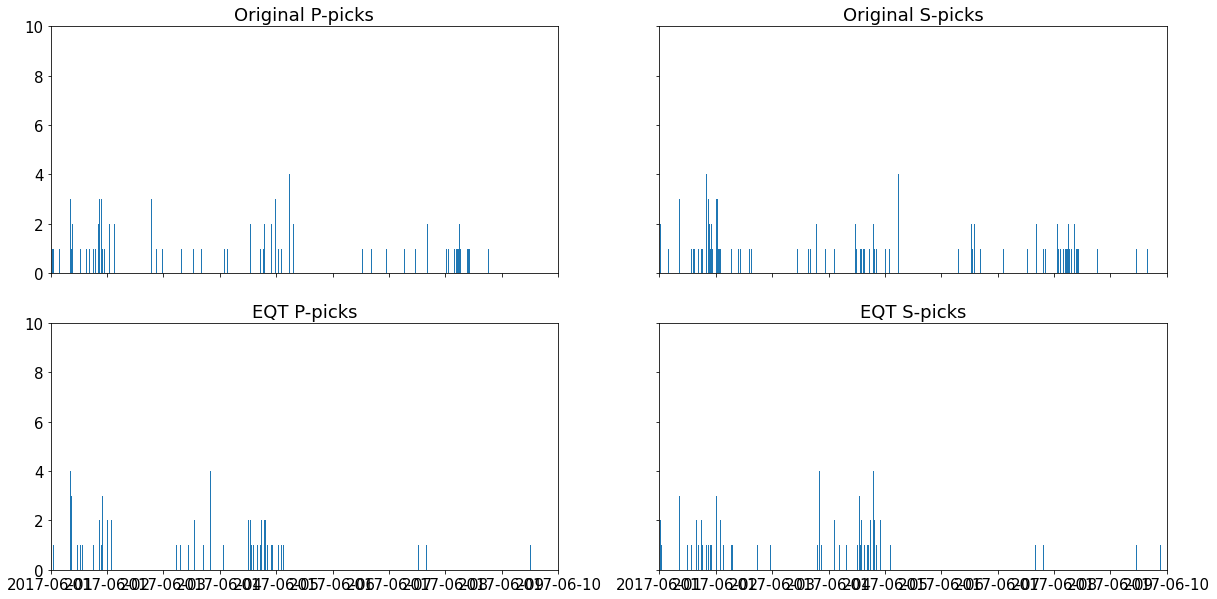

In [29]:
php_picks = eqt[(eqt['phase']=='P') & (eqt['station']=='ENWF')]
phs_picks = eqt[(eqt['phase']=='S') & (eqt['station']=='ENWF')]

p_picks = ground_truth[(ground_truth['phase']=='P') & (ground_truth['station']=='ENWF')]
s_picks = ground_truth[(ground_truth['phase']=='P') & (ground_truth['station']=='ENWF')]


fig, axs = plt.subplots(2,2, figsize=(20,10),sharex=True,sharey=True)
axs[0,0].hist(p_picks['pick_time'],bins=nbins);
axs[0,0].set_title('Original P-picks')
axs[0,1].hist(s_picks['pick_time'],bins=nbins);
axs[0,1].set_title('Original S-picks')
axs[1,0].hist(php_picks['arrival_time'],bins=nbins);
axs[1,0].set_title('EQT P-picks')
axs[1,1].hist(phs_picks['arrival_time'],bins=nbins);
axs[1,1].set_title('EQT S-picks')

axs[1,1].set_ylim([0,10])
axs[1,1].set_xlim([datetime(2017,6,1),datetime(2017,6,10)])

(17318.0, 17327.0)

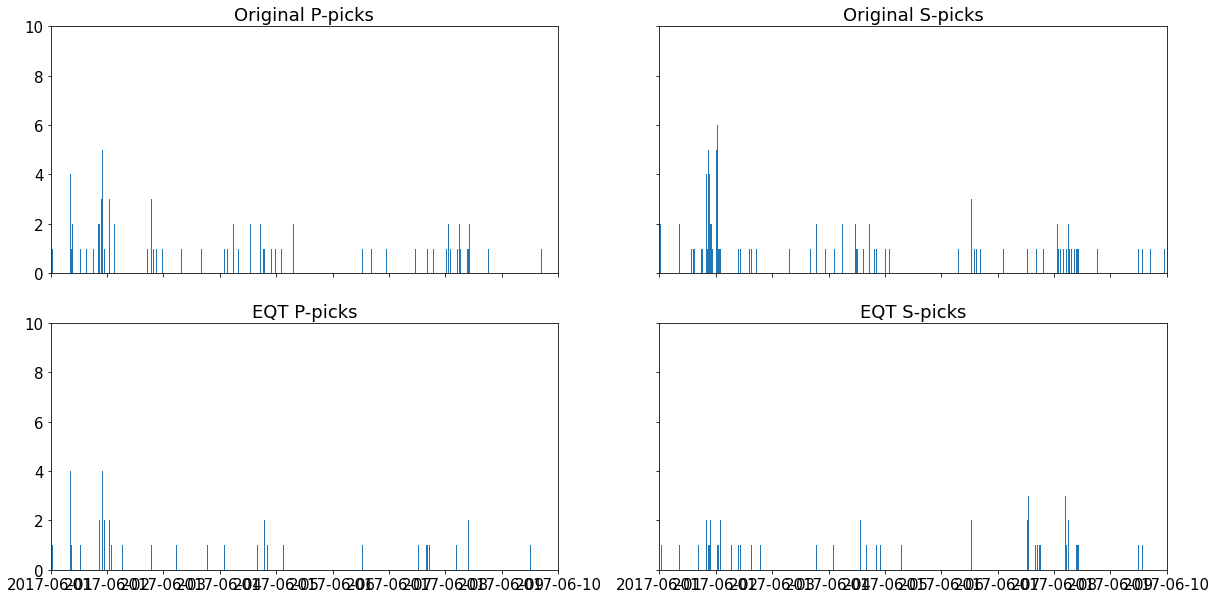

In [30]:
php_picks = eqt[(eqt['phase']=='P') & (eqt['station']=='NCHR')]
phs_picks = eqt[(eqt['phase']=='S') & (eqt['station']=='NCHR')]

p_picks = ground_truth[(ground_truth['phase']=='P') & (ground_truth['station']=='NCHR')]
s_picks = ground_truth[(ground_truth['phase']=='P') & (ground_truth['station']=='NCHR')]


fig, axs = plt.subplots(2,2, figsize=(20,10),sharex=True,sharey=True)
axs[0,0].hist(p_picks['pick_time'],bins=nbins);
axs[0,0].set_title('Original P-picks')
axs[0,1].hist(s_picks['pick_time'],bins=nbins);
axs[0,1].set_title('Original S-picks')
axs[1,0].hist(php_picks['arrival_time'],bins=nbins);
axs[1,0].set_title('EQT P-picks')
axs[1,1].hist(phs_picks['arrival_time'],bins=nbins);
axs[1,1].set_title('EQT S-picks')

axs[1,1].set_ylim([0,10])
axs[1,1].set_xlim([datetime(2017,6,1),datetime(2017,6,10)])